In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
!pip install spacy --quiet
!pip install pyspark --quiet
!pip install langdetect --quiet
!pip install nltk --quiet
!pip install wordcloud --quiet
!pip install plotly --quiet
!pip install missingno --quiet
!pip install gensim --quiet
!python -m spacy download en_core_web_sm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
2023-11-09 11:27:50.117139: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 11:27:50.117207: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 11:27:50.117252: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 11:27:50.127427: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimize

In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

import matplotlib as mpl
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, when, trim
from pyspark.sql.types import StringType
from langdetect import detect

import os
import time
import missingno as msno
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import nltk, re, string, collections, unicodedata

from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
from textblob import TextBlob
from langdetect import detect
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

spark = SparkSession.builder.appName("ElectionTweet").getOrCreate()

In [119]:
sc = spark.sparkContext.getOrCreate()

In [6]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def clean(text):

    stop_words = set(stopwords.words('english'))
    punctuation = string.punctuation
    words = word_tokenize(text)

    def process_word(word):
        word = word.lower()
        word = re.sub('\[.*?\]', '', word)
        word = re.sub('https?://\S+|www\.\S+', '', word)
        word = re.sub('<.*?>+', '', word)
        word = re.sub('\n', '', word)
        word = re.sub(r'@[A-Za-z0-9]+', '', word)
        word = re.sub(r'#', '', word)
        word = re.sub(r'RT[\s]+', '', word)
        word = re.sub(f'[{punctuation}]', '', word)
        word = re.sub(r'\b\w\b', '', word)
        return word

    filtered_words = [process_word(word) for word in words if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_words)
    return filtered_sentence


def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    if score < 0:
        return 0
    elif score==0:
        return 0
    else:
        return 1

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

In [7]:
tweets_biden = pd.read_csv('hashtag_joebiden.csv', lineterminator='\n', parse_dates=True)

In [8]:
tweets_biden['country'].replace({'United States':'United States of America'}, inplace=True)

In [9]:
tweets_biden_tmp = tweets_biden.sort_values('user_followers_count',ascending = False).drop_duplicates(['user_name'])[['tweet','country']]
tweets_biden_us = tweets_biden_tmp.dropna()

In [10]:
tweets_biden_us.count()

tweet      124624
country    124624
dtype: int64

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
tweets_biden_us.reset_index(inplace = True, drop = True)
tweets_biden_us['CleanTweet']=tweets_biden_us['tweet'].apply(clean)
tweets_biden_us['polarity']=tweets_biden_us['CleanTweet'].apply(getPolarity)
tweets_biden_us['sentiment']=tweets_biden_us['polarity'].apply(getAnalysis)
tweets_biden_us['language']=tweets_biden_us["CleanTweet"].apply(detect_language)
tweets_biden_us=tweets_biden_us.loc[tweets_biden_us.language == 'en']
# tweets_biden_us.head()

<ipython-input-12-2473e0006529>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-2473e0006529>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-2473e0006529>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-2473e00

In [13]:
def lemmatizer(text):
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

tweets_biden_us['CleanTweetLemmatize'] =  tweets_biden_us.apply(lambda x: lemmatizer(x['CleanTweet']), axis=1)
tweets_biden_us['CleanTweetLemmatize'] = tweets_biden_us['CleanTweetLemmatize'].str.replace('-PRON-', '')

In [14]:
def clean_text(text):
    hash_tag_removed = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', text)
    hash_tag_removed = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)

    removed_links = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text, flags=re.MULTILINE)
    cleaned = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', removed_links)
    cleaned = ''.join([i if ord(i) < 128 else ' ' for i in cleaned])

    cleaned = cleaned.strip()
    return cleaned

In [15]:
tweets_biden_us_copy = tweets_biden_us

In [16]:
tweets_biden_us['tweet']=tweets_biden_us['CleanTweetLemmatize'].apply(clean_text)

In [17]:
tweets_biden_us.count()

tweet                  74814
country                74814
CleanTweet             74814
polarity               74814
sentiment              74814
language               74814
CleanTweetLemmatize    74814
dtype: int64

In [40]:
mpl.rcParams['figure.figsize']=(12.0,12.0)
mpl.rcParams['font.size']=12
mpl.rcParams['savefig.dpi']=100
mpl.rcParams['figure.subplot.bottom']=.1
# stopwords = set(STOPWORDS)

In [41]:
wordcloud = WordCloud(background_color='white',
                      max_words=500,
                      max_font_size=40,
                      random_state=42
                      ).generate(str(tweets_biden_us['tweet']))

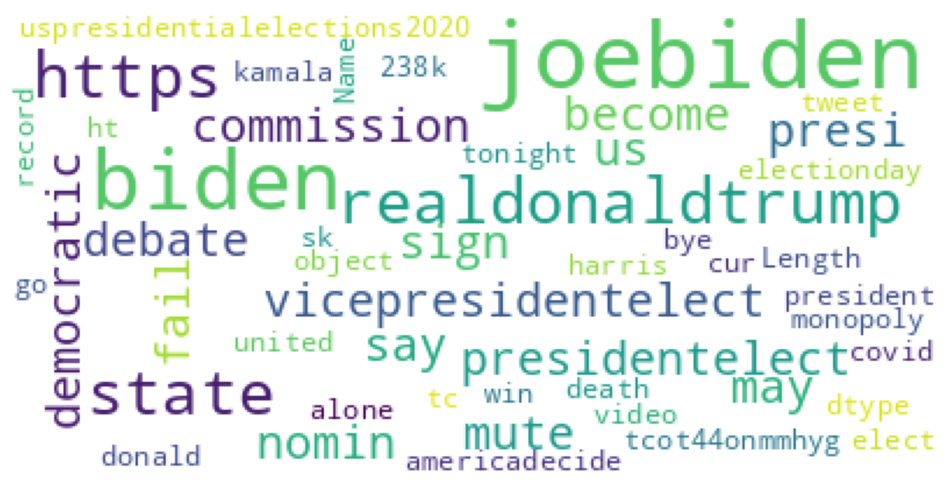

In [42]:
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [18]:
text_data = [text.split() for text in tweets_biden_us['tweet']]
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [44]:
lda_model20 = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=20, random_state=0, passes=10)
topics = lda_model20.print_topics(num_words=20)

In [61]:
lda_model10 = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=0, passes=10)

In [47]:
topics10 = lda_model10.print_topics(num_words=20)

In [19]:
lda_model5 = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=0, passes=10)
topics5 = lda_model5.print_topics(num_words=20)

In [63]:
lda_model3 = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=0, passes=10)

In [64]:
topics3 = lda_model3.print_topics(num_words=20)

In [45]:
# Compute Coherence Score for 20 topics
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

nCoherence Score:  0.4213782263596011


In [62]:
# Compute Coherence Score for 10 topics
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model10, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

nCoherence Score:  0.39572411445862227


In [68]:
# Compute Coherence Score for 5 topics
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model5, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

nCoherence Score:  0.44908663875913674


In [65]:
# Compute Coherence Score for 3 topics
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model3, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

nCoherence Score:  0.37742635994261153


In [20]:
lda_model = lda_model5

In [69]:
for topic in topics5:
    print(topic) #for 5 topics

(0, '0.008*"mail" + 0.007*"sir" + 0.007*"na" + 0.005*"town" + 0.005*"abc" + 0.005*"nbc" + 0.004*"aoc" + 0.004*"wan" + 0.004*"berniesander" + 0.004*"sick" + 0.004*"endorse" + 0.004*"bitcoin" + 0.004*"hall" + 0.003*"pro" + 0.003*"fund" + 0.003*"scandal" + 0.003*"bidencrimefamiiy" + 0.003*"bidencorruption" + 0.002*"pelosi" + 0.002*"msm"')
(1, '0.089*"joebiden" + 0.067*"https" + 0.032*"biden" + 0.031*"president" + 0.025*"kamalaharris" + 0.017*"america" + 0.017*"election2020" + 0.016*"congratulation" + 0.015*"donaldtrump" + 0.013*"bidenharris2020" + 0.011*"usa" + 0.010*"joe" + 0.009*"bidenharis2020" + 0.009*"united" + 0.008*"states" + 0.008*"usaelection2020" + 0.008*"new" + 0.007*"election" + 0.007*"elect" + 0.007*"uselection2020"')
(2, '0.042*"biden" + 0.035*"\'" + 0.026*"joebiden" + 0.019*"trump" + 0.014*"vote" + 0.013*"https" + 0.010*"go" + 0.010*"not" + 0.010*""" + 0.010*"people" + 0.009*"get" + 0.008*"realdonaldtrump" + 0.008*"like" + 0.008*"say" + 0.007*"know" + 0.007*"year" + 0.006*"

In [21]:
!pip install prettytable --quiet

In [23]:
word_distributions = []

for topic_id, word_distribution_text in topics5:
    word_prob_pairs = word_distribution_text.split('+')

    topic_word_dist = []

    for word_prob_pair in word_prob_pairs:
        parts = word_prob_pair.strip().split('*')
        probability = parts[0].strip()
        word = parts[1].strip(' "')
        topic_word_dist.append((word, probability))

    word_distributions.append((topic_id, topic_word_dist))

#word_distributions contains a list of topics with their word distributions
print(word_distributions)

[(0, [('twitter', '0.022'), ('china', '0.018'), ('hunter', '0.016'), ('hunterbiden', '0.012'), ('bye', '0.011'), ('corruption', '0.008'), ('email', '0.007'), ('facebook', '0.006'), ('nypost', '0.005'), ('bidencrimefamiily', '0.005'), ('fbi', '0.004'), ('story', '0.004'), ('account', '0.004'), ('son', '0.004'), ('chinese', '0.004'), ('joke', '0.004'), ('censorship', '0.003'), ('family', '0.003'), ('laptop', '0.003'), ('donaldjtrumpjr', '0.003')]), (1, [('biden', '0.044'), ("'", '0.033'), ('joebiden', '0.022'), ('trump', '0.018'), ('vote', '0.017'), ('https', '0.013'), ('go', '0.010'), ('', '0.010'), ('not', '0.010'), ('get', '0.009'), ('realdonaldtrump', '0.009'), ('people', '0.008'), ('say', '0.008'), ('like', '0.007'), ('amp', '0.007'), ('know', '0.006'), ('year', '0.006'), ('make', '0.005'), ('need', '0.005'), ('see', '0.005')]), (2, [('biden', '0.021'), ('vote', '0.017'), ('state', '0.016'), ('cnn', '0.011'), ('blue', '0.010'), ('georgia', '0.010'), ('pennsylvania', '0.010'), ('mich

In [24]:
from prettytable import PrettyTable
for topic_id, word_dist in word_distributions:
    table = PrettyTable()
    table.field_names = ["Word", "Probability"]

    for word, probability in word_dist:
        table.add_row([word, probability])

    table.title = f"Topic {topic_id} - Word Distribution"
    table.align["Word"] = "l"
    table.align["Probability"] = "r"

    print(table)

+---------------------------------+
|   Topic 0 - Word Distribution   |
+-------------------+-------------+
| Word              | Probability |
+-------------------+-------------+
| twitter           |       0.022 |
| china             |       0.018 |
| hunter            |       0.016 |
| hunterbiden       |       0.012 |
| bye               |       0.011 |
| corruption        |       0.008 |
| email             |       0.007 |
| facebook          |       0.006 |
| nypost            |       0.005 |
| bidencrimefamiily |       0.005 |
| fbi               |       0.004 |
| story             |       0.004 |
| account           |       0.004 |
| son               |       0.004 |
| chinese           |       0.004 |
| joke              |       0.004 |
| censorship        |       0.003 |
| family            |       0.003 |
| laptop            |       0.003 |
| donaldjtrumpjr    |       0.003 |
+-------------------+-------------+
+-------------------------------+
|  Topic 1 - Word Distribution

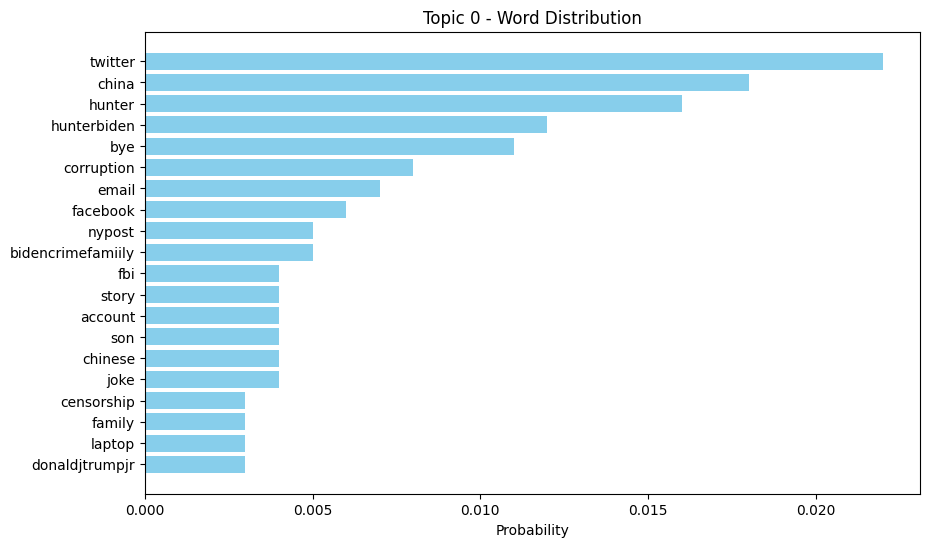

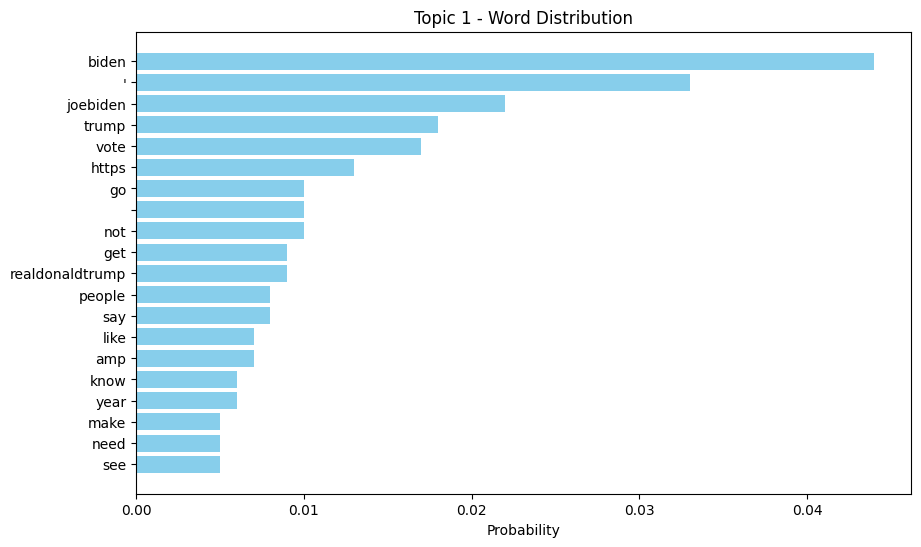

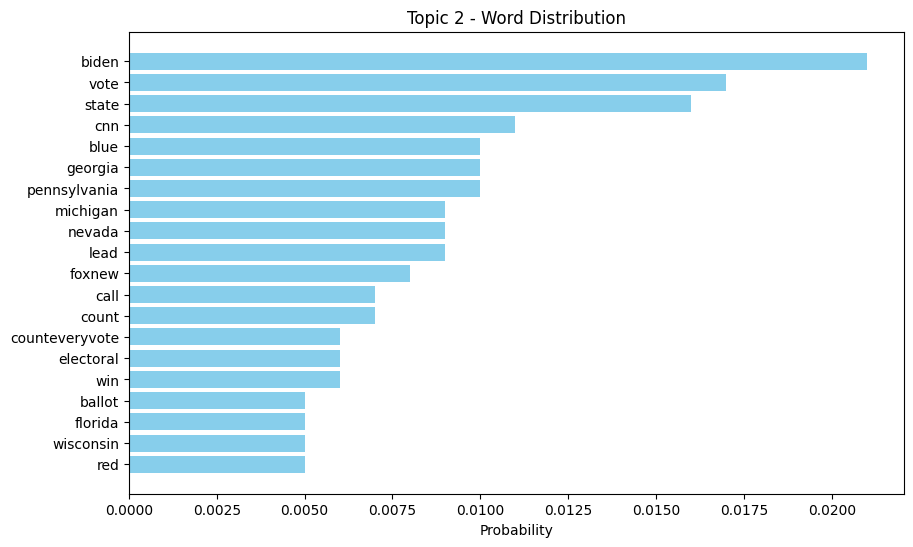

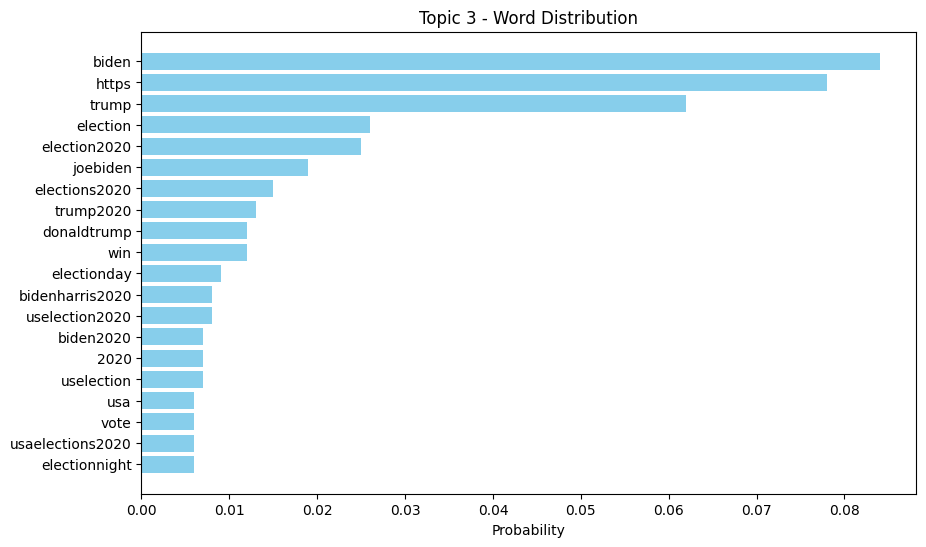

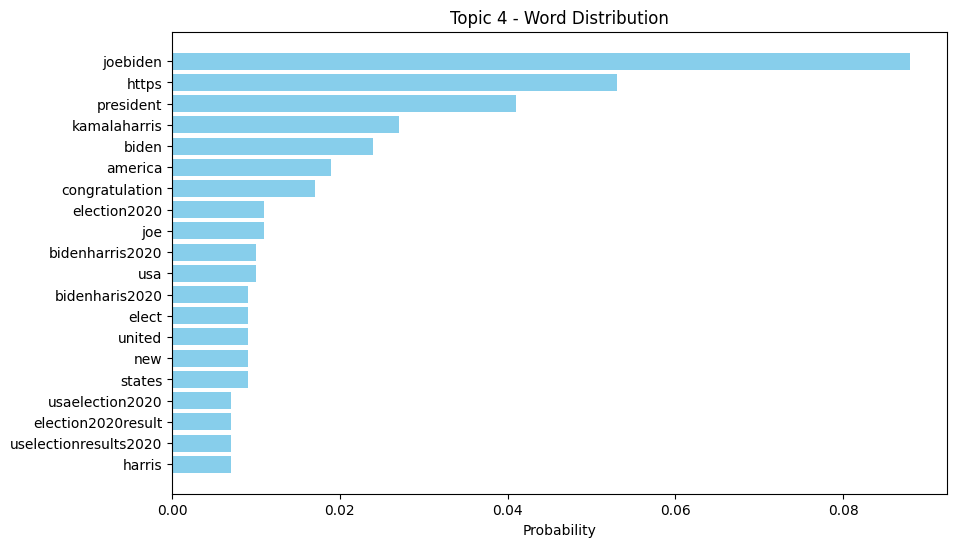

In [25]:
for topic_id, word_dist in word_distributions:
    words, probabilities = zip(*word_dist)
    words = [word for word in words]
    probabilities = [float(prob) for prob in probabilities]

    plt.figure(figsize=(10, 6))
    plt.barh(words, probabilities, color='skyblue')
    plt.xlabel('Probability')
    plt.title(f'Topic {topic_id} - Word Distribution')
    plt.gca().invert_yaxis()
    plt.show()

In [26]:
tweets_biden_us['TopicAssignment'] = [lda_model[corpus[i]] for i in range(len(tweets_biden_us))]
tweets_biden_us[['TopicAssignment', 'CleanTweet']]

,TopicAssignment,CleanTweet
1,"[(0, 0.014392246), (1, 0.3182734), (2, 0.01418...",presidentelect joebiden vicepresidentelect k...
2,"[(1, 0.130417), (3, 0.6595451), (4, 0.19016275)]",us debate commission says mute democratic nomi...
3,"[(1, 0.520308), (2, 0.09545827), (3, 0.2194658...",signs us becoming failed state joebiden may p...
5,"[(0, 0.039200928), (1, 0.03947563), (2, 0.0391...",ा््रपति ुा ीतने े ा ्ा ोे ाइडे uspresidentia...
8,"[(0, 0.209828), (1, 0.03258522), (2, 0.0325008...",bye donald biden kamala https tcot44onmmhyg
...,...,...
124615,"[(0, 0.012519181), (1, 0.012604506), (2, 0.083...",46th president unites states congratulations ...
124616,"[(0, 0.01439195), (1, 0.2765915), (2, 0.014712...",realdonaldtrump president elect joebiden cur...
124617,"[(0, 0.022276837), (1, 0.022847796), (2, 0.022...",biden going win tonight biden electionday h...
124618,"[(0, 0.046843037), (1, 0.5782828), (2, 0.09018...",238k deaths recorded united states covid alone...


In [78]:
tweets_biden_us.columns

Index(['tweet', 'country', 'CleanTweet', 'polarity', 'sentiment', 'language',
       'CleanTweetLemmatize', 'TopicAssignment'],
      dtype='object')

In [27]:
tweets_biden_df=tweets_biden_us.drop(['CleanTweet','CleanTweetLemmatize','country','language'],axis=1)

In [28]:
tweets_biden_df.head()

,tweet,polarity,sentiment,TopicAssignment
1,presidentelect joebiden vicepresidentelect ...,0.0000,0,"[(0, 0.014392246), (1, 0.3182734), (2, 0.01418..."
2,us debate commission say mute democratic nomin...,0.0000,0,"[(1, 0.130417), (3, 0.6595451), (4, 0.19016275)]"
3,sign we become fail state joebiden may presi...,-0.0375,0,"[(1, 0.520308), (2, 0.09545827), (3, 0.2194658..."
5,uspresidentialelections2020 joebiden video...,0.0000,0,"[(0, 0.039200928), (1, 0.03947563), (2, 0.0391..."
8,bye donald biden kamala https tcot44onmmhyg,0.0000,0,"[(0, 0.209828), (1, 0.03258522), (2, 0.0325008..."


In [29]:
def get_top_topic(topic_assignments):
    return max(topic_assignments, key=lambda x: x[1])[0]

In [30]:
tweets_biden_df['TopTopic'] = tweets_biden_df['TopicAssignment'].apply(get_top_topic)
tweets_biden_df[['TopTopic', 'tweet']]

,TopTopic,tweet
1,4,presidentelect joebiden vicepresidentelect ...
2,3,us debate commission say mute democratic nomin...
3,1,sign we become fail state joebiden may presi...
5,3,uspresidentialelections2020 joebiden video...
8,3,bye donald biden kamala https tcot44onmmhyg
...,...,...
124615,4,46th president unite state congratulation ...
124616,4,realdonaldtrump president elect joebiden cur...
124617,3,biden go win tonight biden electionday ht...
124618,1,238k death record united states covid alone ...


In [31]:
filtered_data = tweets_biden_df[tweets_biden_df['TopTopic'] == 3]

print(filtered_data[['TopTopic', 'tweet']])

        TopTopic                                              tweet
2              3  us debate commission say mute democratic nomin...
5              3  uspresidentialelections2020   joebiden   video...
8              3  bye donald   biden   kamala https   tcot44onmmhyg
14             3  joebiden head   whitehouse   pm modi invest mu...
21             3  trump kay apnay bhi phir gaye   americans nay ...
...          ...                                                ...
124594         3  election2020   election2020result   elections2...
124603         3  big day usa   would vote    uselections2020   ...
124609         3  congrats biden   donald trump go    borisjohns...
124613         3  fuck biden trump   vote dwight schrute   obvio...
124617         3  biden go win tonight    biden   electionday ht...

[17005 rows x 2 columns]


pyLDAvis

In [127]:
tweets_biden_df.head()

,tweet,polarity,sentiment,TopicAssignment,TopTopic
1,presidentelect joebiden vicepresidentelect ...,0.0000,0,"[(0, 0.014392246), (1, 0.3182734), (2, 0.01418...",4
2,us debate commission say mute democratic nomin...,0.0000,0,"[(1, 0.130417), (3, 0.6595451), (4, 0.19016275)]",3
3,sign we become fail state joebiden may presi...,-0.0375,0,"[(1, 0.520308), (2, 0.09545827), (3, 0.2194658...",1
5,uspresidentialelections2020 joebiden video...,0.0000,0,"[(0, 0.039200928), (1, 0.03947563), (2, 0.0391...",3
8,bye donald biden kamala https tcot44onmmhyg,0.0000,0,"[(0, 0.209828), (1, 0.03258522), (2, 0.0325008...",3


In [128]:
tweets_biden_df_copy = tweets_biden_df

In [129]:
tweets_biden_df_copy = tweets_biden_df_copy.drop(['TopicAssignment','TopTopic','polarity'],axis=1)

In [130]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, ArrayType

# Define the schema
schema = StructType([
    StructField("tweet", StringType(), nullable=True),
    #StructField("polarity", DoubleType(), nullable=True),
    StructField("sentiment", IntegerType(), nullable=True)
    #StructField("TopicAssignment", ArrayType(StringType()), nullable=True),
    #StructField("TopTopic", IntegerType(), nullable=True)
])

tweet_spark_df = spark.createDataFrame(tweets_biden_df_copy,schema)

In [131]:
tweet_spark_df.show()

+--------------------+---------+
|               tweet|sentiment|
+--------------------+---------+
|presidentelect   ...|        0|
|us debate commiss...|        0|
|sign we become fa...|        0|
|uspresidentialele...|        0|
|bye donald   bide...|        0|
|hollywood celebri...|        1|
|joebiden head   w...|        1|
|live    joebiden ...|        1|
|people cheer cele...|        0|
|biden administrat...|        1|
|joebiden enlist a...|        0|
|trump kay apnay b...|        0|
|campaign across b...|        1|
|pic   america cel...|        1|
|news outlet proje...|        0|
|timeline    joebi...|        1|
|president   donal...|        1|
|joebiden verge be...|        1|
|uselections2020 p...|        1|
|update    joebide...|        1|
+--------------------+---------+
only showing top 20 rows



<Axes: title={'center': 'score'}>

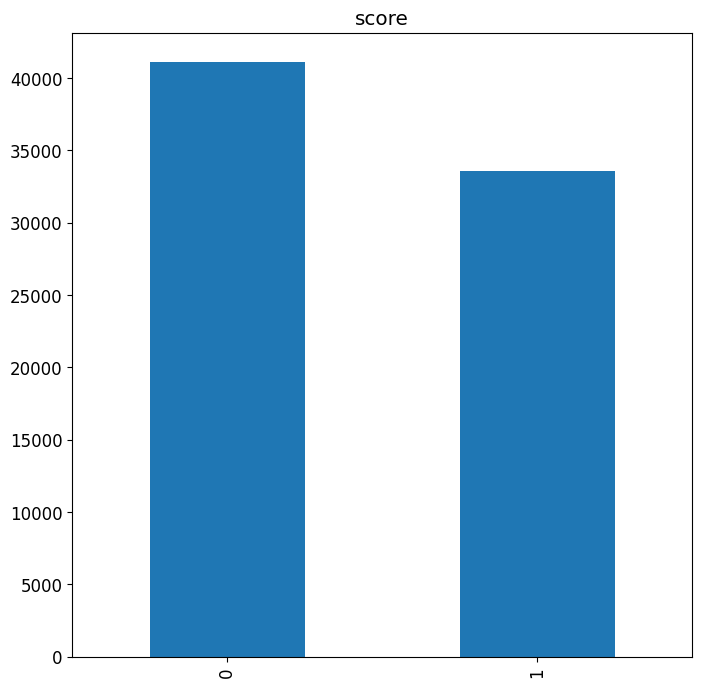

In [103]:
# Grouping the scores and plotting bar graph
sentiment_count =  tweets_biden_df['sentiment'].value_counts()
sentiment_count.plot(kind="bar", y="score", title="score", figsize=[8, 8])

In [132]:
from pyspark.sql.types import StringType, BooleanType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml import Pipeline

In [134]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="rawFeatures")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])
model = pipeline.fit(tweet_spark_df)
tfidf_df = model.transform(tweet_spark_df)

In [135]:
training_data, test_data = tfidf_df.randomSplit([0.7, 0.3], seed=42)

In [136]:
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")
evaluator = BinaryClassificationEvaluator(labelCol="sentiment")

In [137]:
lr = LogisticRegression(featuresCol="features", labelCol="sentiment")

lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 20, 30]) \
    .build()

In [138]:
crossval_lr = CrossValidator(estimator=lr, estimatorParamMaps=lr_param_grid, evaluator=evaluator, numFolds=10)

DO NOT RUN BELOW CELL

In [134]:
lr_model = crossval_lr.fit(training_data)
lr_predictions = lr_model.transform(test_data)
lr_auc = evaluator.evaluate(lr_predictions)
lr_f1 = evaluator_f1.evaluate(lr_predictions)
lr_best_params = lr_model.bestModel.extractParamMap()
print(f"Logistic Regression AUC: {lr_auc}")
print(f"Logistic Regression F1-SCORE: {lr_f1}")
print(f"Best Params for Logistic Regression: {lr_best_params}")

Logistic Regression AUC: 0.9618924156486038
Logistic Regression F1-SCORE: 0.8934267085513865
Best Params for Logistic Regression: {Param(parent='LogisticRegression_9ca6d1f3444a', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_9ca6d1f3444a', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5, Param(parent='LogisticRegression_9ca6d1f3444a', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto', Param(parent='LogisticRegression_9ca6d1f3444a', name='featuresCol', doc='features column name.'): 'features', Param(parent='LogisticRegression_9ca6d1f3444a', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_9ca6d1f3444a', name='labelCol', doc='label colum

In [ ]:
probabilities = lr_predictions.select("probability").rdd.map(lambda row: row[0][1]).collect()  # Assuming 1 is the positive class
labels = lr_predictions.select("prediction").rdd.map(lambda row: float(row[0])).collect()

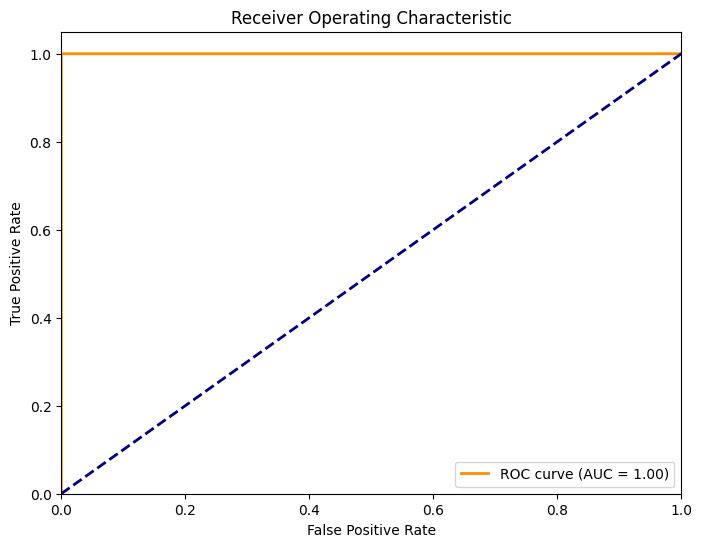

In [140]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
fpr1, tpr1, thresholds1 = roc_curve(labels, probabilities)

# Compute AUC
roc_auc = auc(fpr1, tpr1)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

LR with Probability Distribution

In [35]:
tweets_biden_df2=tweets_biden_df.drop(['polarity','TopTopic'],axis=1)
tweets_biden_df2['TopicAssignment'] = tweets_biden_df2['TopicAssignment'].apply(lambda x: ', '.join([f'{pair[1]:.6f}' for pair in x]))
tweets_biden_df2['tweet_with_probabilities'] = tweets_biden_df2['tweet'] + ' ' + tweets_biden_df2['TopicAssignment']
tweets_biden_df2.head()

In [43]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, ArrayType

# Define the schema
schema = StructType([
    StructField("tweet_with_probabilities", StringType(), nullable=True),
    #StructField("polarity", DoubleType(), nullable=True),
    StructField("sentiment", IntegerType(), nullable=True)
    #StructField("TopicAssignment", ArrayType(StringType()), nullable=True)
    #StructField("TopTopic", IntegerType(), nullable=True)
])

tweet_spark_df2 = spark.createDataFrame(tweets_biden_df2,schema)

In [146]:
tweet_spark_df2.show()

+------------------------+---------+
|tweet_with_probabilities|sentiment|
+------------------------+---------+
|    presidentelect   ...|        0|
|    us debate commiss...|        0|
|    sign we become fa...|        0|
|    uspresidentialele...|        0|
|    bye donald   bide...|        0|
|    hollywood celebri...|        1|
|    joebiden head   w...|        1|
|    live    joebiden ...|        1|
|    people cheer cele...|        0|
|    biden administrat...|        1|
|    joebiden enlist a...|        0|
|    trump kay apnay b...|        0|
|    campaign across b...|        1|
|    pic   america cel...|        1|
|    news outlet proje...|        0|
|    timeline    joebi...|        1|
|    president   donal...|        1|
|    joebiden verge be...|        1|
|    uselections2020 p...|        1|
|    update    joebide...|        1|
+------------------------+---------+
only showing top 20 rows



In [47]:
tokenizer = Tokenizer(inputCol="tweet_with_probabilities", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="rawFeatures")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])
model = pipeline.fit(tweet_spark_df2)
tfidf_df = model.transform(tweet_spark_df2)

In [48]:
training_data, test_data = tfidf_df.randomSplit([0.7, 0.3], seed=42)

In [54]:
lr_model2 = crossval_lr.fit(training_data)
lr_predictions2 = lr_model2.transform(test_data)
lr_auc2 = evaluator.evaluate(lr_predictions2)
lr_f12 = evaluator_f1.evaluate(lr_predictions2)
lr_best_params2 = lr_model2.bestModel.extractParamMap()
print(f"Logistic Regression AUC: {lr_auc2}")
print(f"Logistic Regression F1-SCORE: {lr_f12}")
print(f"Best Params for Logistic Regression: {lr_best_params2}")

Logistic Regression AUC: 0.9588622019932732
Logistic Regression F1-SCORE: 0.8891095179134039
Best Params for Logistic Regression: {Param(parent='LogisticRegression_e7e881ee8507', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_e7e881ee8507', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5, Param(parent='LogisticRegression_e7e881ee8507', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto', Param(parent='LogisticRegression_e7e881ee8507', name='featuresCol', doc='features column name.'): 'features', Param(parent='LogisticRegression_e7e881ee8507', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_e7e881ee8507', name='labelCol', doc='label colum

In [103]:
probabilities = lr_predictions2.select("probability").rdd.map(lambda row: row[0][1]).collect()  # Assuming 1 is the positive class
labels = lr_predictions2.select("prediction").rdd.map(lambda row: float(row[0])).collect()

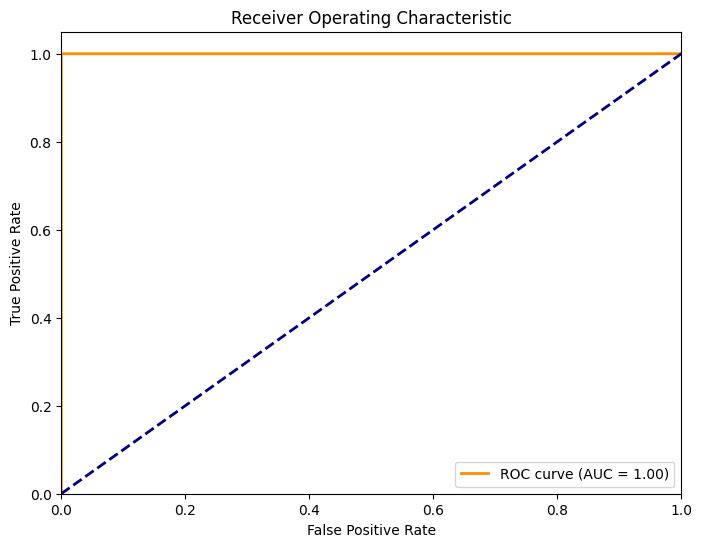

In [123]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(labels, probabilities)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [86]:
print(lr_predictions2.show(truncate=False))

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [57]:
#lr_predictions2.write.text("lr_predictions2.txt")
# print(lr_predictions2)
lr_predictions2.show()

+------------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|tweet_with_probabilities|sentiment|               words|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+------------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    "   declare   rep...|        0|[", , , declare, ...|(262144,[24862,69...|(262144,[24862,69...|[1.57716451835497...|[0.82880256970182...|       0.0|
|    "   latinamerica ...|        1|[", , , latinamer...|(262144,[8538,499...|(262144,[8538,499...|[1.40104375841009...|[0.80234946501589...|       0.0|
|    "   rudygiuliani ...|        0|[", , , rudygiuli...|(262144,[24862,37...|(262144,[24862,37...|[1.53489472755067...|[0.82272134285822...|       0.0|
|    " ' easy parent m...|        1|[", ', easy, pare...|(262144,[5451,167...|(262